# California Dataset t-SNE Grid

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.


In [2]:
from training.utils import *

c:\program files\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\program files\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import numpy as np
from pprint import pprint
from tqdm import tqdm
import sklearn
from sklearn.manifold import TSNE
import sys
from PIL import Image
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, output_file
import bokeh
import skimage

output_notebook()

Loading BokehJS ...

In [4]:
BAND_STATS = {
        'mean': {
            'B01': 340.76769064,
            'B02': 429.9430203,
            'B03': 614.21682446,
            'B04': 590.23569706,
            'B05': 950.68368468,
            'B06': 1792.46290469,
            'B07': 2075.46795189,
            'B08': 2218.94553375,
            'B8A': 2266.46036911,
            'B09': 2246.0605464,
            'B11': 1594.42694882,
            'B12': 1009.32729131
        },
        'std': {
            'B01': 554.81258967,
            'B02': 572.41639287,
            'B03': 582.87945694,
            'B04': 675.88746967,
            'B05': 729.89827633,
            'B06': 1096.01480586,
            'B07': 1273.45393088,
            'B08': 1365.45589904,
            'B8A': 1356.13789355,
            'B09': 1302.3292881,
            'B11': 1079.19066363,
            'B12': 818.86747235
        }
    }

BAND_STATS_CA = {"mean": {
            "B02": 704.0660306667106,
            "B03": 1013.6625595886348,
            "B04": 1177.3966978795684,
            "B05": 1559.4157583764888,
            "B06": 2271.823718038332,
            "B07": 2570.590654856275,
            "B08": 2729.77884789601,
            "B8A": 2782.5820922432317,
            "B11": 2633.2600006272755,
            "B12": 1960.1242074549111
        },
        "std": {
            "B02": 275.44633762623107,
            "B03": 341.9727574411451,
            "B04": 469.3295063736902,
            "B05": 439.3445385554108,
            "B06": 405.9869176625257,
            "B07": 462.80766566429446,
            "B08": 453.4091836811935,
            "B8A": 465.3067073795589,
            "B11": 570.6215399891606,
            "B12": 593.4589000748651
        }}

In [38]:
def generate_tsne_grid(saved_model, files, num_images, render_images, batch_size, ca_flag, expanded_labels,
                       bokeh_flag, label, output, seed):    
    SCALE_FACTOR = 4000 if ca_flag else 3000
    
    # Get the data
    data = get_batched_dataset(files, batch_size, ca=ca_flag, expanded_labels=expanded_labels)

    loaded_model = tf.keras.models.load_model(saved_model)
    loaded_model.summary()
    
    def denorm_img(img):
        
        if ca_flag:
            band_stats = BAND_STATS_CA
        else:
            band_stats = BAND_STATS
        
        return np.stack([(img[:,:,0]* band_stats['std']['B04']+ band_stats['mean']['B04'])/ SCALE_FACTOR,
                        (img[:,:,1]* band_stats['std']['B03']+ band_stats['mean']['B03'])/ SCALE_FACTOR,
                        (img[:,:,2]* band_stats['std']['B02']+ band_stats['mean']['B02'])/ SCALE_FACTOR], axis=2)
    def rgb_to_rgba32(img):
        """
        Convert an RGB image to a 32 bit-encoded RGBA image.
        """
        img = denorm_img(img)
        # Ensure it has three channels
        if len(img.shape) != 3 or img.shape[2] !=3:
            raise RuntimeError('Input image is not RGB.')

        # Get image shape
        n, m, _ = img.shape

        # Convert to 8-bit, which is expected for viewing
        im_8 = np.uint8(img*255)

        # Add the alpha channel, which is expected by Bokeh
        im_rgba = np.dstack((im_8, 255*np.ones_like(im_8[:,:,0])))

        # Reshape into 32 bit. Must flip up/down for proper orientation
        return np.flipud(im_rgba.view(dtype=np.int32).reshape(n, m))
    
    
    # Loop over the batches and grab the latent vectors and image vectors
    count = 0
    preds = []
    images = []
    labels = []
    for image_batch, label_batch in data: 
        count += batch_size
        preds.append(loaded_model.predict(image_batch))
        images.append(image_batch)
        labels.append(label_batch)
        if count >= num_images:
            break
            

    X = np.concatenate(preds)
    print(f'Activation Vector Shape: {X.shape}')
    images = np.concatenate(images)
    print(f'Image Vector Shape: {images.shape}')
    labels = np.concatenate(labels)
          
    tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2,random_state=seed).fit_transform(X)
    
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
    
    
    render_count = 0
    if bokeh_flag:
        
        p_width = 700
        p_height = 500
        p = figure(plot_height=p_height, plot_width = p_width,
                   x_range =[0,p_width], y_range=[0,p_height],
                   tools='pan,box_zoom,wheel_zoom,reset')
        for img, x, y in zip(images, tx, ty):
            im_disp = rgb_to_rgba32(img)
            n, m = im_disp.shape
            p.image_rgba(image=[im_disp],
                          x=int((p_width-m)*x),
                          y=int(p_height-n-(p_height-n)*y),
                           dw=m/5,dh=n/5)
        
            render_count += 1
            if render_count > render_images :
                break

        output_file(f"{output}.html", title=label)
        bokeh.io.show(p)
        
        
    else:
        width = 4000
        height = 3000
        max_dim = 100

        full_image = Image.new('RGBA', (width, height))
        
        for img, x, y in zip(images, tx, ty):
            tile = Image.fromarray(np.uint8(denorm_img(img)*255))
            rs = max(1, tile.width/max_dim, tile.height/max_dim)
            tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
            full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
            
            render_count += 1
            if render_count > render_images :
                break

        plt.figure(figsize = (16,12))
        plt.imshow(full_image)
        
    return tsne, labels

## Run for California

In [39]:
# Define location for dataset
dataset_filepath = "D:\Berkeley\CA_tfrecords\CV.tfrecord"
#model_filepath = "D:\Berkeley\CASprings_SimCLR_pretrain_ResNet152_E50_B32_V2.h5"
model_filepath = "D:\Berkeley\CA_SimCLR_pretrain_ResNet152_ADAM_E50_B32_V2.h5"

In [40]:
# Generate Interactive Map
# generate_tsne_grid(model_filepath, dataset_filepath, 
#                    num_images=1024, render_images=1024, batch_size=32, 
#                    ca_flag=True, bokeh_flag=True,
#                    label='California - SimCLR 50 Epochs',
#                    output='california_simclr_e50_t1', seed=42)

In [37]:
# Generate Static image
tsne, labels = generate_tsne_grid(model_filepath, dataset_filepath, 
                   num_images=4096, render_images=1024, batch_size=32, 
                   ca_flag=True, expanded_labels=False, bokeh_flag=False,
                   label='California - SimCLR 50 Epochs',
                   output='california_simclr_e50_t1', seed=42)

Filenames: D:\Berkeley\CA_tfrecords\CV.tfrecord
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 10)]    0         
_________________________________________________________________
resnet152 (Functional)       (None, 4, 4, 2048)        58392896  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_1 

TypeError: 'NoneType' object is not iterable

## Run for BigEarthNet

In [41]:
# Define location for dataset
dataset_filepath = "D:\Berkeley\BigEarthNet_S2\\tfrecords_10_percent_bal_exp\\train.tfrecord"
model_filepath = "D:\Berkeley\BigEarthNet_SimCLR_pretrain_ResNet152_E50_B32_V2.h5"

Filenames: D:\Berkeley\BigEarthNet_S2\tfrecords_10_percent_bal_exp\train.tfrecord
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 10)]    0         
_________________________________________________________________
resnet152 (Functional)       (None, 4, 4, 2048)        58392896  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_____________________________________________

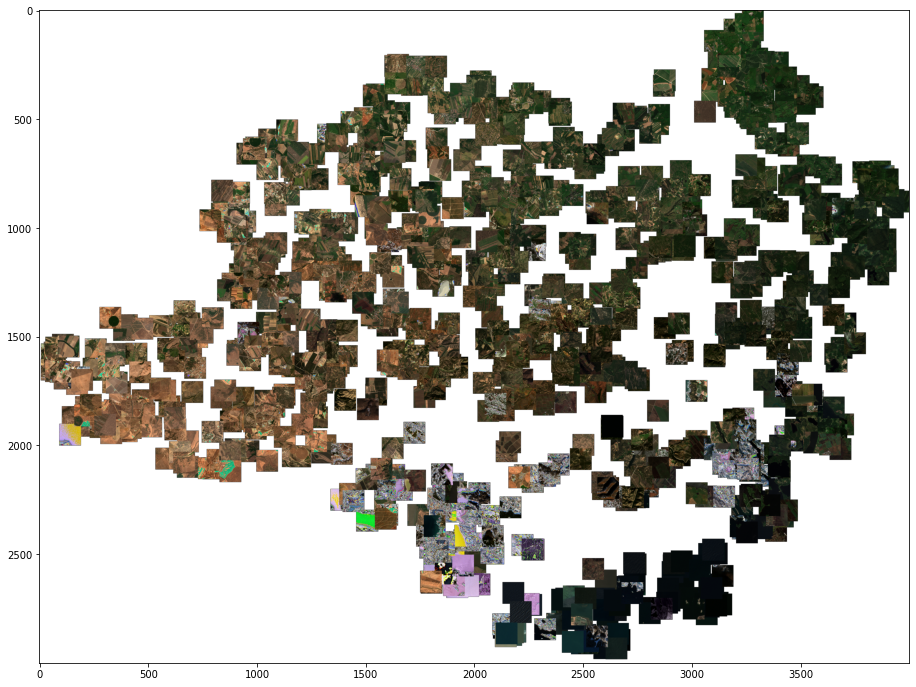

In [42]:
# Generate Static image
tsne, labels = generate_tsne_grid(model_filepath, dataset_filepath, 
                   num_images=4096, render_images=1024, batch_size=32, 
                   ca_flag=False, expanded_labels=False, bokeh_flag=False,
                   label='BigEarthNet - SimCLRv2 50 Epochs',
                   output='bigearthnet_simclr_e50_t1', seed=42)

In [43]:
import matplotlib.cm as cm

In [135]:
irr_tsne = tsne[np.where(labels)[0],:]
no_irr_tsne = tsne[np.where(labels ==0)[0],:]

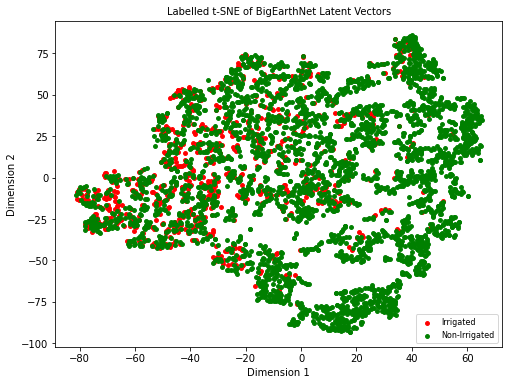

In [136]:
plt.figure(figsize=(8,6))
irr_plt = plt.scatter(irr_tsne[:,0], -irr_tsne[:,1],c='r', s=15)
no_irr_plt = plt.scatter(no_irr_tsne[:,0], -no_irr_tsne[:,1],c='g', s=15)
plt.title("Labelled t-SNE of BigEarthNet Latent Vectors", fontsize=10)
plt.legend((irr_plt,no_irr_plt), ("Irrigated", "Non-Irrigated"), fontsize=8, loc = 'lower right')
plt.xlabel("Dimension 1", fontsize=10)
plt.ylabel("Dimension 2", fontsize=10)
plt.show()

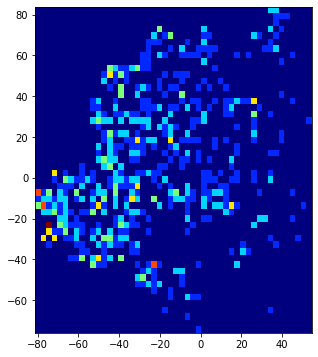

In [140]:
heatmap, xedges, yedges = np.histogram2d(irr_tsne[:,0], -irr_tsne[:,1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(8,6))
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.jet)
plt.show()

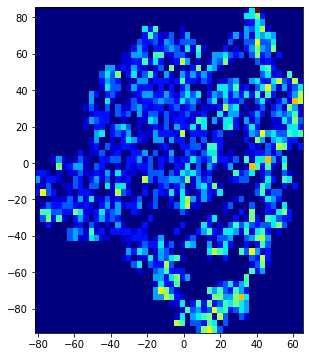

In [141]:
heatmap, xedges, yedges = np.histogram2d(no_irr_tsne[:,0], -no_irr_tsne[:,1], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.figure(figsize=(8,6))
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower',cmap=cm.jet)
plt.show()

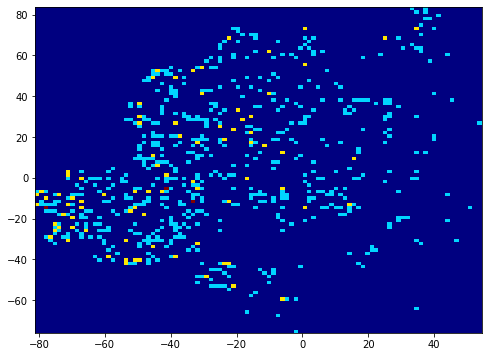

In [143]:
plt.figure(figsize=(8,6))
plt.hist2d(irr_tsne[:,0], -irr_tsne[:,1],bins=100,cmap=cm.jet)
plt.show()